# In this notebook, we are going to implement MLP model to analysis the data
## https://en.wikipedia.org/wiki/Convolutional_neural_network


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [2]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [3]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id     dx    dx_type   age     sex  \
9864  HAM_0003157  ISIC_0031578  akiec      histo  65.0    male   
1374  HAM_0005911  ISIC_0028127    mel      histo  70.0  female   
7067  HAM_0002100  ISIC_0031440     nv      histo  55.0    male   
7293  HAM_0005880  ISIC_0025117     nv      histo  25.0  female   
9247  HAM_0001356  ISIC_0026333     nv  consensus  60.0  female   

         localization  label  
9864  upper extremity      0  
1374             back      4  
7067             back      5  
7293             hand      5  
9247            chest      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

In [5]:
import math
#assign weight
#sum of the data
total_data = 0
num_classes = 7
for num_of_data in df['label'].value_counts():
    total_data+=num_of_data
print("total number of data: ",total_data)
print(df['label'].value_counts())
#calc weight for each class
class_weight ={}
for index, value in df.label.value_counts().iteritems():
    v1 = math.log(total_data/(float(value)*num_classes))
    class_weight[index] = v1 if v1>1.0 else 1.0

for i in class_weight:
    print(i," ",class_weight[i])

total number of data:  10015
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
5   1.0
4   1.0
2   1.0
1   1.0237058335894402
0   1.4759689281473518
6   2.310102041443345
3   2.520996970681355


In [6]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [7]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

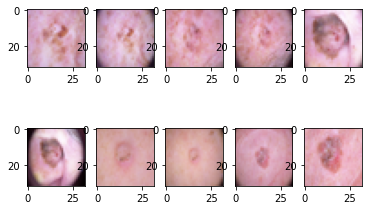

In [8]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [9]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
data = data.reshape(total_data,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=87,stratify=label_to_one_hot)


In [10]:
#setup MLP model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Dense
num_classes = 7
dimension = image_size*image_size*3

model = Sequential()

#input Dense layer of 64x64x3 image input:
#with normal distribution + relu activation
model.add(Dense(units=1024,input_dim=dimension,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.15))

#hidden layer 2
model.add(Dense(units=512,input_dim=dimension,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.2))

#hidden layer 3
model.add(Dense(units=256,input_dim=dimension,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.25))

#hidden layer 4
model.add(Dense(units=128,input_dim=dimension,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.25))

#output Dense layer with 7 classes + softmax activation
model.add(Dense(units=num_classes,kernel_initializer='uniform',activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [11]:
# Train
try:
    model.load_weights('model/MLP_weight.h5')
except:
    print("new model")

batch_size = 512
epochs = 200

train_history = model.fit(
    x=train_data,y=train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2,class_weight=class_weight)

model.save_weights('model/MLP_weight.h5')

new model
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
13/13 - 1s - loss: 1.5418 - acc: 0.6201 - val_loss: 1.2089 - val_acc: 0.6569
Epoch 2/200
13/13 - 0s - loss: 1.3717 - acc: 0.6726 - val_loss: 1.1704 - val_acc: 0.6569
Epoch 3/200
13/13 - 0s - loss: 1.3103 - acc: 0.6726 - val_loss: 1.1478 - val_acc: 0.6569
Epoch 4/200
13/13 - 0s - loss: 1.2651 - acc: 0.6726 - val_loss: 1.0949 - val_acc: 0.6569
Epoch 5/200
13/13 - 0s - loss: 1.2120 - acc: 0.6726 - val_loss: 1.1457 - val_acc: 0.6569
Epoch 6/200
13/13 - 0s - loss: 1.2056 - acc: 0.6726 - val_loss: 1.0667 - val_acc: 0.6569
Epoch 7/200
13/13 - 0s - loss: 1.1856 - acc: 0.6726 - val_loss: 1.0731 - val_acc: 0.6569
Epoch 8/200
13/13 - 0s - loss: 1.1818 - acc: 0.6726 - val_loss: 1.0457 - val_acc: 0.6569
Epoch 9/200
13/13 - 0s - loss: 1.1597 - acc: 0.6726 - val_loss: 1.0241 - val_acc: 0.6569
Epoch 10/200
13/13 - 0s - loss: 1.1390 - acc: 0.672

In [12]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

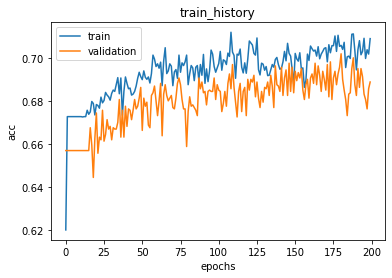

In [13]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

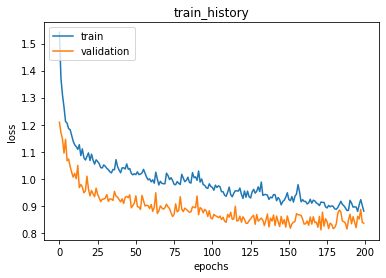

In [14]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [15]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

63/63 [==============================] - 0s 2ms/step - loss: 0.8143 - acc: 0.7084
Test accuracy: 0.7084373235702515


In [16]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))
mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))

[5 5 5 ... 5 2 2]
predict   0   1   2  4     5  6
label                          
0         8   9  24  1    22  1
1        15  12  21  0    51  4
2         2   1  76  5   136  0
3         4   1   7  0    11  0
4         0   1  21  7   194  0
5         4   0  25  4  1307  1
6         2   1   0  0    16  9
predicted  akiex  bcc  bkl  mel    nv  vasc
actual                                     
akiex          8    9   24    1    22     1
bcc           15   12   21    0    51     4
bkl            2    1   76    5   136     0
df             4    1    7    0    11     0
mel            0    1   21    7   194     0
nv             4    0   25    4  1307     1
vasc           2    1    0    0    16     9
